In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Introduction to AI and OpenVino

## Session 05

## Implementation of Perceptron

<img src='../../prasami_images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align = "left"/>

In [2]:
# Lets import some libraries
import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import matplotlib as mpl

import seaborn as sns

from sklearn import datasets

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
 
%matplotlib inline

In [3]:
# Some Basic Parameters for housekeeping

# set location of input files:
inpDir = os.path.join('..', '..', 'input')

# set location of inputs for this module
moduleDir = 'machine_learning'
# set location of output files
outDir = os.path.join('..', 'output')

# define and set random state 
RANDOM_STATE = 24
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

# parameters for Matplotlib
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 9),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'large',
          'savefig.dpi': 75,
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 1,
          'legend.numpoints' : 1
         }

CMAP = plt.cm.coolwarm
plt.rcParams.update(params);
plt.set_cmap(CMAP);

TEST_SIZE = 0.2 # Test size
EPOCHS = 2000  # number of epochs
ALPHA = 0.01  # learning rate


<Figure size 1500x900 with 0 Axes>

## Generate Data Set
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.

In [4]:
X, y = datasets.make_moons(n_samples=1000, shuffle=True, noise=0.2, random_state=RANDOM_STATE)
X[:5], y[:5]

(array([[ 0.90633951,  0.90267624],
        [-1.11536828,  0.75579289],
        [ 1.88769158,  0.4175967 ],
        [-0.93345034, -0.02299851],
        [-0.96872877,  0.06396285]]),
 array([0, 0, 1, 0, 0]))

## 4. Visualization
<p style="font-family: Arial; font-size:1.2em;">
DataFrames are easier to visualize
</p>

In [5]:
data_df = pd.DataFrame(X, columns = ['A', 'B'])
data_df['target'] = y
data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


In [6]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [7]:
data_df.describe()

,A,B,target
count,1000.000000,1000.000000,1000.00000
mean,0.490841,0.239025,0.50000
std,0.898951,0.540082,0.50025
min,-1.688795,-0.955280,0.00000
25%,-0.149565,-0.205090,0.00000
50%,0.500100,0.241163,0.50000
75%,1.095048,0.680394,1.00000
max,2.419113,1.612075,1.00000


In [8]:
# Lets look at what unique values are there in the data
data_df.target.unique()

array([0, 1])

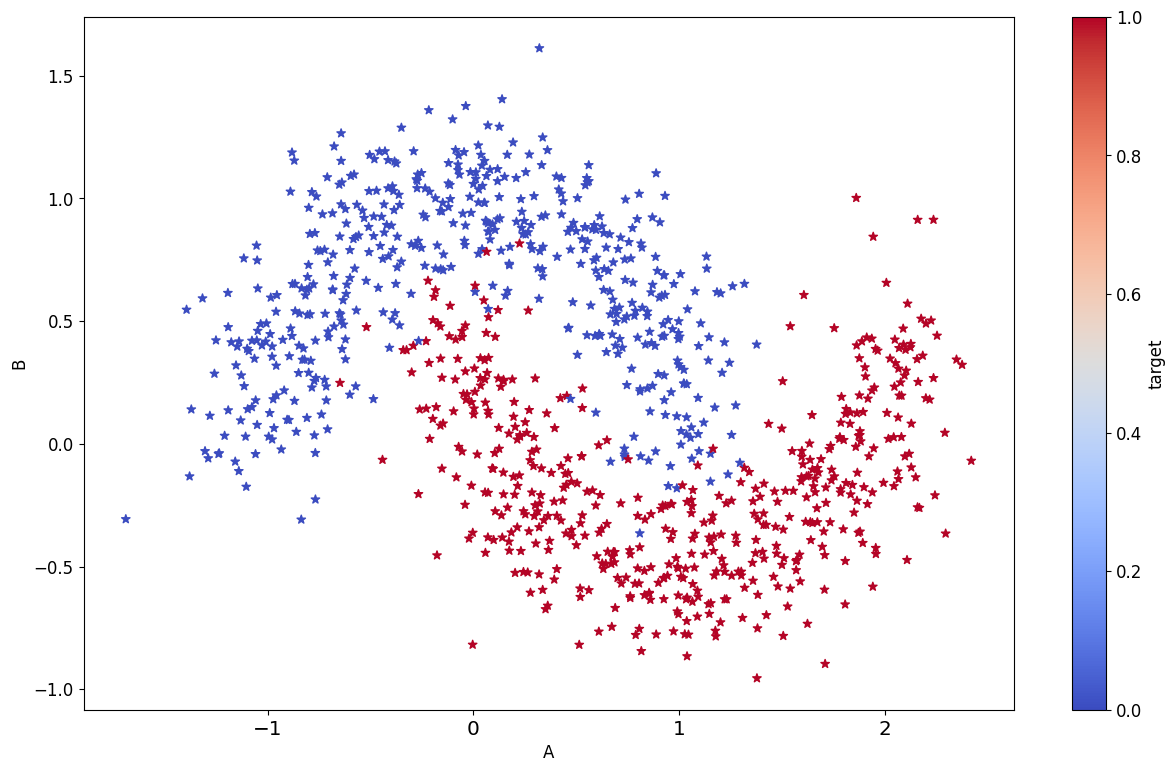

In [9]:
# Plot the data
data_df.plot.scatter('A', 'B', 
                     s=40,
                     marker = '*', 
                     c = 'target',
                     cmap=CMAP);

In [10]:
data_train, data_test = data_df.values[:900], data_df.values[900:]

print (data_train.shape, data_test.shape)

print (type(data_train), type(data_test))

(900, 3) (100, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Over to Perceptron

<div class="alert alert-block alert-info" style="font-family: Arial; font-size:1.1em;">

Our output is binary. To keep the code in line with what we discussed in previous lecture, we will simply output 1 for positive values of 'z' and zero for negative values.
</div>
<img src="../../images/dnn_nb_s03_fig1.png" width='350' align = 'left'>


$$
\begin{aligned}
z & = 1.0 \circ w_0 + x_1 \circ w_1 + x_2 \circ w_2 \\
\mathrm{or}\\
z & = X\circ W \\
\end{aligned}
$$
<br/>


$$
\begin{equation*}
    \hat{y} = \begin{cases}
      1.0, & \text{for z>=0}\  \\
      0.0, & \text{for z<0}\
    \end{cases}
\end{equation*}
$$

<div class="alert alert-block alert-info" style="font-family: Arial; font-size:1.1em;">
<p>
As we know that adjustments in the weights are simply (a-$\hat{y}$). Hence we will be adjusting weights by learning_rate * (a-$\hat{y}$). 
</p>
<p>
    <strong>Note:</strong> Take learning_rate ($\alpha$) as some constant and we will circle back to learning_rate after some sessions.
</p>
</div>

In [11]:
# A function to make predictions
def predict(row, weights):
    '''
    Args: 
        row: one data row.
        weights: array with first value as b and then w1 and w2.
    return:
        0 if sum is negative else 1. Simplest form of activation function.
    '''
    
    # building up z = X * W + b
    z = weights[0] # Initialize with b, bias
    
    for i in range(len(row)-1):
        
        z += weights[i + 1] * row[i] # and weights are added here to the values

    return 1 if z >=0  else 0 # simplest form of activation function

**Unit Test** : Its advisable to test the function.

In [12]:
#Unit test
weights = [0.1, 2.0, 1.0]

display(data_df.loc[0])

predict(data_df.loc[0].values, weights)

A         0.906340
B         0.902676
target    0.000000
Name: 0, dtype: float64

1

## Back-propagation - Estimate Perceptron weights
$
\begin{aligned}
\partial{z}  & = a - y \\
\partial{b}  & = \partial{z} \\
\partial{w_1}  & = x_1 \circ \partial{z}\\
\partial{w_2}  & = x_2 \circ \partial{z}\\
\end{aligned}
$
    <hr>
$
\begin{aligned}
b & = b -  \frac{1}{m} (\alpha \circ \partial{b}) \\
w_1  & = w_1 - \frac{1}{m}(\alpha \circ \partial{w_1} )\\
w_2  & = w_2 - \frac{1}{m}(\alpha \circ \partial{w_2} )\\
\end{aligned}
$


In [27]:
def train_weights(train, alpha, n_epoch):
    '''
    Args: 
        train: training dataset
        alpha: learning rate
        n_epoch: number of epoch to train
    return:
        errors: list containing errors
        weights: list of updated weights
    '''
    
    # We will be appending errors in a list
    errors = []
    
    #Initialize Weights. In theory b can be zero. For sake of simplicity lets initialize b as well.         
    weights = np.random.rand(train.shape[1])
    
    # find m; number of samples
    m = train.shape[0]
    
    for epoch in range(n_epoch): # loop for number of epochs
        
        sum_error = 0.0
        
        ###---------------------------------------------------
        ### Note: we are adjusting weights in each of the row.
        ### It is one of the techniques of optimization
        ### More optimization technique later
        ###---------------------------------------------------
        for row in train:
            
            prediction = predict(row, weights) # make prediction by row
                
            dz = prediction - row[-1] # dz = (a-y) 
            
            sum_error += (prediction - row[-1])**2 # cumulative error for this epoch
            
            # In stochastic gradient descend we need to devide by m...  TTMM :)
            
            weights[0] = weights[0] - alpha * dz / m  # update b
            
            for i in range(len(row)-1):
                
                weights[i + 1] = weights[i + 1] - alpha * dz * row[i] / m # update rest of the weights
        
        errors.append(sum_error / m) # append average error
        
    return errors, weights

In [14]:
# Lets fix some value for learning rate and number of epoched
alpha = ALPHA
n_epoch = EPOCHS

errors, weights = train_weights(data_train, alpha, n_epoch)

print(weights)

[-4.91888502e-06  1.96260734e-05 -3.67686263e-05]


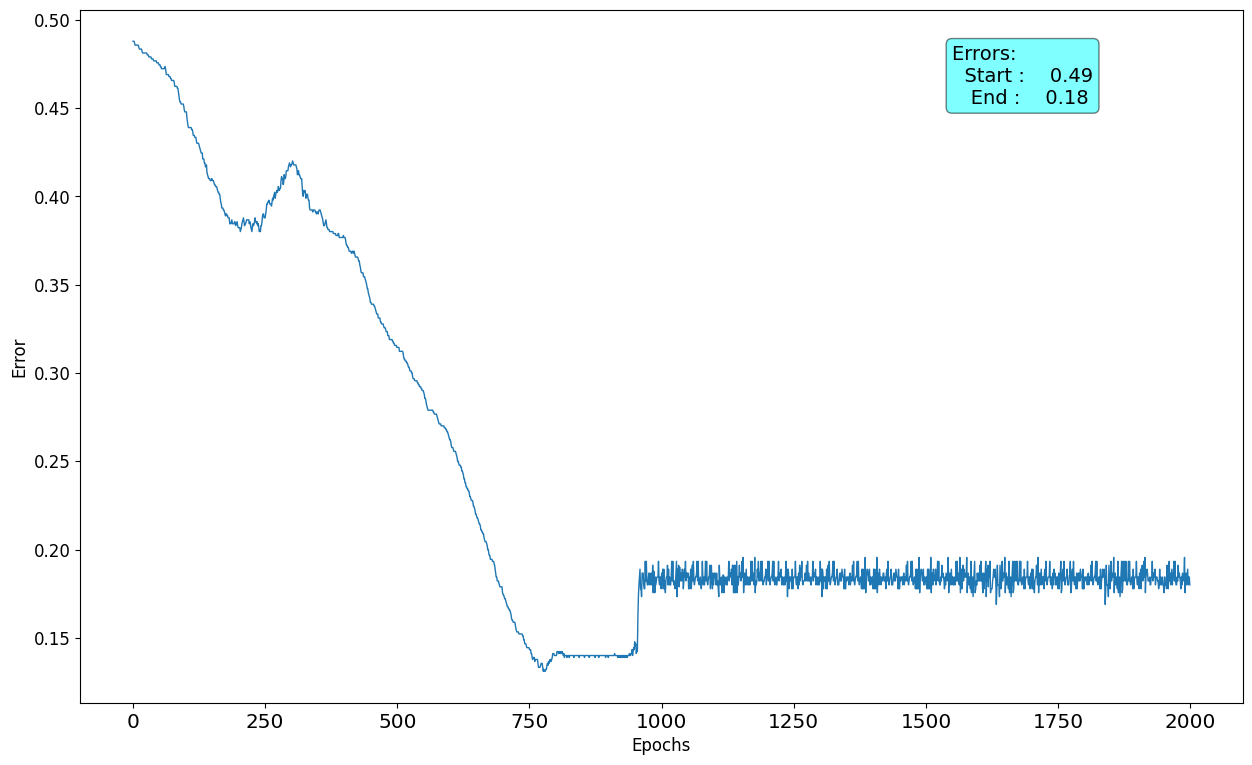

In [15]:
fig, ax = plt.subplots()
ax.plot(errors);

# Little beautification
txtstr = "Errors: \n  Start : {:7.2f}\n   End : {:7.2f}".format(errors[0],errors[-1]) #text to plot

# Properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

# Place a text box in upper left in axes coords

ax.text(0.75, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")
ax.set_ylabel("Error");

## Predictions

### Train Set

In [16]:
predictions = []

for row in data_train:
    
    prediction = predict(row, weights)
    
    predictions.append(prediction)

In [17]:
accuracy_score(data_train[:,-1], predictions)

0.8466666666666667

### Test Set

In [18]:
predictions = []

for row in data_test:
    
    prediction = predict(row, weights)
    
    predictions.append(prediction)

In [19]:
accuracy_score(data_test[:,-1], predictions)

0.89

In [20]:
cm = confusion_matrix(data_test[:,-1], predictions)
cm

array([[54,  4],
       [ 7, 35]])

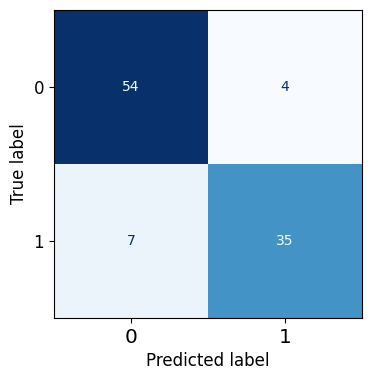

In [21]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', colorbar=False)

plt.show();

In [22]:
dm = 0.05

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))

In [23]:
print (np.arange(x_min, x_max, dm).shape)
XX = np.c_[xx.ravel(), yy.ravel()]
print(XX.shape)
XX = np.hstack( ( XX, np.ones((XX.shape[0],1)) ) )
print(XX.shape)

(103,)
(7416, 2)
(7416, 3)


In [24]:
XX

array([[-2.18879487, -1.45527983,  1.        ],
       [-2.13879487, -1.45527983,  1.        ],
       [-2.08879487, -1.45527983,  1.        ],
       ...,
       [ 2.81120513,  2.09472017,  1.        ],
       [ 2.86120513,  2.09472017,  1.        ],
       [ 2.91120513,  2.09472017,  1.        ]])

In [25]:
def fn_plot_decision_boundary(X):
    
    fig, ax = plt.subplots();
    
    dm = 0.05
    
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, dm),
                         np.arange(y_min, y_max, dm))
    
    XX = np.c_[xx.ravel(), yy.ravel()]

    XX = np.hstack( ( XX, np.ones((XX.shape[0],1)) ) ) # because predict function is expecting 3 values per col
    
    
    y_pred = []
    
    for row in (XX):

        y_p = predict(row, weights)
        y_pred.append(y_p)
        
    Z = np.array(y_pred).reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.6, cmap=plt.cm.Paired)
    ax.scatter(X[:, 0], X[:, 1], c=X[:, 2],
                                  s=30, edgecolor='k', cmap=plt.cm.bwr)
    ax.set_title('Decision Boundary')

    ax.set_xlabel('A')
    ax.set_ylabel('B')
    plt.show()

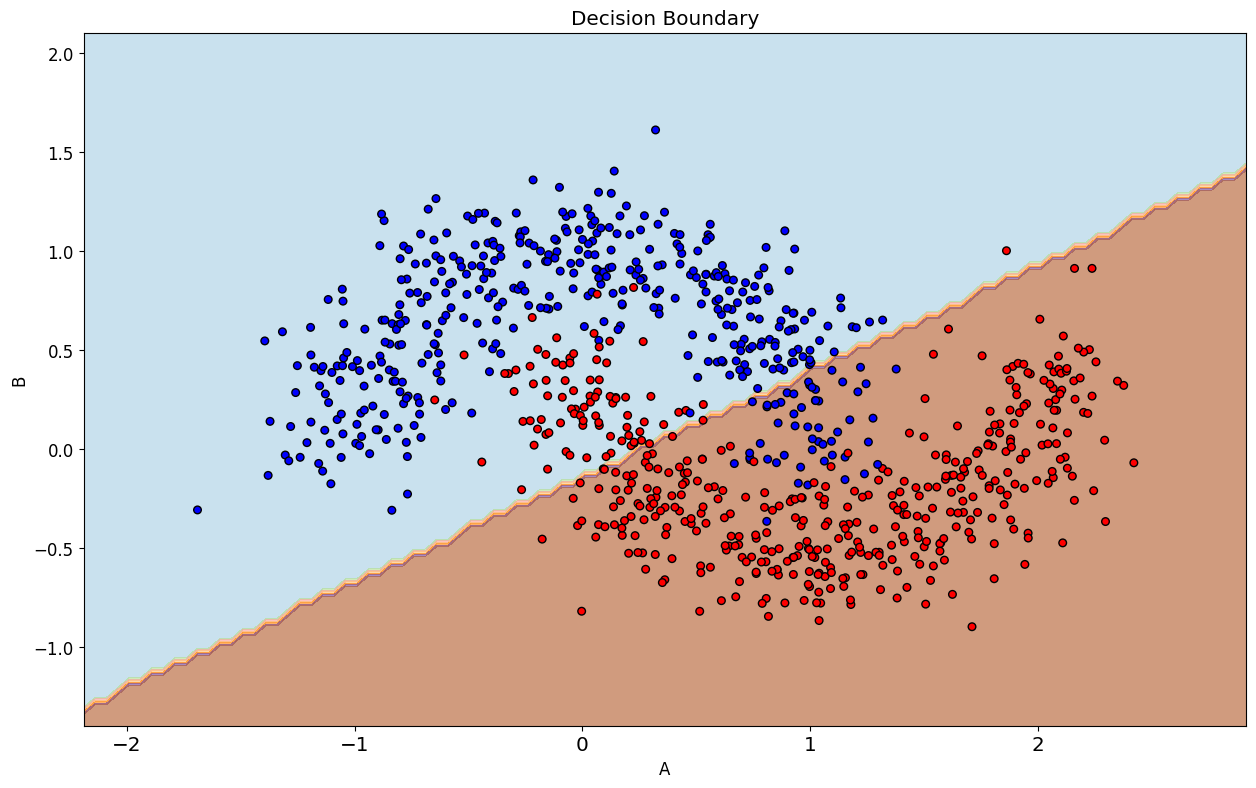

In [26]:
fn_plot_decision_boundary(data_train)

## A note on Loss Function
In logistic regression we are looking for if it is correct class or not. For example, we want to know if there is a car in the picture or not.
    
Mathematically speaking:

$\hat{y} = p(y=1|x)$ i.e. given training sample $x$, we want to know probability of $y$ being 1.<br>

Alternatively:

If there is a car in the picture.  $\Rightarrow$  $y$ = 1 then $p(y|x)$ = $\hat{y}$.  

if there is **no** car in the picture.$\Rightarrow$ $y$ = 0 then $p(y|x)$ = 1 - $\hat{y}$.  

We can summarize two equation as:

$p(y|x)$ = $\hat{y}^{y} * (1 - \hat{y}) ^{(1-y)}$

Above equation is $\hat{y}$ for y = 1 and (1 - $\hat{y}$) for y = 0.

Taking log of above equation:

$
\begin{aligned}
log [ p(y|x) ] & = log[\hat{y}^{y} * (1 - \hat{y}) ^{(1-y)}]\\
& = y * log(\hat{y}) + (1-y) * log(1 - \hat{y})\\
\end{aligned}
$

Since we aim to minimize above function, add negative sign and our loss function becomes

$
\begin{aligned}
L(\hat{y},y) =  -[y * log\hat{y} + (1-y) * log(1-\hat{y})]\\
\text{or}\\
L(a,y) =  - [ y * log ( a ) + ( 1 - y ) * log( 1 - a ) ]\\
\end{aligned}
$

|Case| y |Loss| a |-log(a)|-log(1-a)|
|:-: |:-:|:-: |:-:|  :-: |   :-:  |
| 1  | 0 | -log( 1 - a )| 0.000001 |13.8155|**1 e-6**|
| 2  | 0 | -log( 1 - a )| 0.999999 |1 e-6|**13.8155**|
| 3  | 1 | -log( a )| 0.000001 |**13.8155**|1 e-6|
| 4  | 1 | -log( a )| 0.999999 |**1 e-6**|13.8155|

We want to sum it up for all samples in the dataset. Hence:

$
\begin{aligned}
p(\text{all ys | all rows of x}) & =  \Pi_{i=0}^m p(y|x)\\
log [ p(\text{all ys | all rows of x})] & =  log [ \Pi_{i=0}^m p(y|x) ]\\
& =  \sum_{i=0}^m log [ p(y|x) ] \\
& =  \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\text{Divide it by m to better scale the costs}\\
& = \frac{1}{m} * \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\end{aligned}
$

### Introducing $\mathrm{sigmoid}$ function for our binary output.
$$
\begin{aligned}
z & = x_1 . w_1 + x_2 . w_2 + b_1 \\
a & = \hat{y} = \sigma(z)\\
dz & = (a - y) \\
db & = dz\\
b & = b - \alpha . db\\
dw_1 & = x_1. dz\\
dw_2 & = x_2.dz\\
w_1 & = w_1 - \alpha . dw_1\\
w_2 & = w_1 - \alpha . dw_2\\
\end{aligned}
$$
### Sigmoid function
$$
\begin{align}
a &= \sigma(z)\\
&= \dfrac{1}{1 + e^{-z}}\\
\end{align}
$$
### Derivative of sigmoid function
$$
\begin{align}
\partial{a} &= \partial{(\sigma(z))}\\
&= \dfrac{\partial}{\partial{z}} \left[ \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{\partial}{\partial{z}} \left( 1 + \mathrm{e}^{-z} \right)^{-1} \\
&= -(1 + e^{-z})^{-2}(-e^{-z}) \\
&= \dfrac{e^{-z}}{\left(1 + e^{-z}\right)^2} \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{e^{-z}}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{(1 + e^{-z}) - 1}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ \dfrac{1 + e^{-z}}{1 + e^{-z}} - \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ 1 - \dfrac{1}{1 + e^{-z}} \right] \\
&= \sigma(z) \circ (1 - \sigma(z))\\
&= a \circ (1 - a)
\end{align}
$$
